In [ ]:
!pip install z3_solver

     |████████████████████████████████| 32.9 MB 456 kB/s 


# Generating Adversarial Examples with SAT Solvers

---

Adversarial examples are specialized inputs created with the intension of confusing a neural network classifier, resulting in a misprediction of the given image.  

We can include these adversarial images back into our train set to help improve model perforamnce. 

It's important to set a limit on how much we can change an input image. Completely distorting an input will likely not lead to any improvement on the models performance. 

In this notebook we demo searching for adversarial examples in two different networks. The first is a binary classifier with two features and the other is a multi-class classifier on the infamous mnist dataset. 



# Demo 1 | Binary Classifier w/ 2 Features
---

# Build a Toy Dataset

This dataset will be very simple. The decision boundary will be described by a function $f$ where $$f(x) = 4 \sin{x} + 5$$

The we assign a label for $y$ to $(p_1,p_2)\in X$

$$y = \begin{cases} 0 & \text{if }f(p_1) > p_2\\ 1 & \text{otherwise }\end{cases}$$

Intuitively, points that sit below the decision boundary are given $0$ label, and points on and above the decision boundary are given a $1$ label. 


In [ ]:
from random import random, seed, randint
import pylab
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

def build_dataset(f,n_points,x_scale=10,y_scale=10):
  X, labels = [], []
  for _ in range(n_points):
    x,y = random()*x_scale, random()*y_scale
    if f(x) < y: # y is above the function
      labels.append(1)
    else:
      labels.append(0)
    X.append([x,y])
  return X, labels

seed(1)
f = lambda x: 4*np.sin(x) + 5

X,y = build_dataset(f,5000)


## Visualize Data

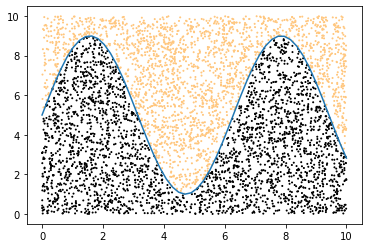

In [ ]:
data_xs = [ i[0] for i in X ]
data_ys = [ i[1] for i in X ]

# visualize data
xs = np.linspace(0,10,50)
ys = list(map(f,xs))
pylab.plot(xs,ys) # true curve
plt.scatter(data_xs,data_ys, c=y, cmap="copper", s=1) # dataset 

## Convert To Tensors and Train Test Split

In [ ]:
import torch
from sklearn.model_selection import train_test_split

X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor, 
                                                    test_size=0.20, 
                                                    random_state=1)

print("Train: ", len(X_train))
print("Test: ", len(X_test))

Train:  4000
Test:  1000


## Convert To Batches

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CustomTensorDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y
    self.len = len(X)
  def __len__(self):
    return self.len 
  def __getitem__(self,index):
    return self.X[index], self.y[index]
BATCH_SIZE = 5
trainloader = DataLoader(CustomTensorDataset(X_train,y_train), batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(CustomTensorDataset(X_test,y_test), batch_size=BATCH_SIZE, shuffle=True)

# Multilayer Perceptron



In [ ]:
import torch.nn as nn
import torch.nn.functional as F 

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(2,5)
    self.linear2 = nn.Linear(5,10)
    self.linear3 = nn.Linear(10,5)
    self.output = nn.Linear(5,2)

  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear3(x))
    return self.output(x)

net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.8)

## Train Model

In [ ]:
N_epochs = int(1e2)
for epoch in range(N_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(input=outputs, target=labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 600 == 599:    # print every 600 mini-batches
            if epoch % 100 == 99:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 300))
            running_loss = 0.0

print('Finished Training')

[100,   600] loss: 0.270
Finished Training


## Test Model

Accuracy of the network over 1000 images: 93.3%


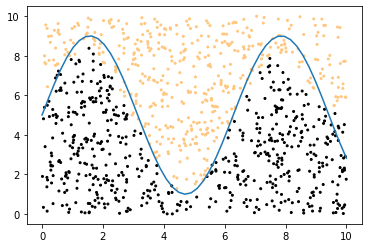

In [ ]:
correct = 0
total = 0
test_labels, test_xs, test_ys = [], [], []
with torch.no_grad():
  for data in testloader:
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
    # Graph
    inputs_T = inputs.T.tolist()
    test_xs += inputs_T[0]
    test_ys += inputs_T[1]
    test_labels += predicted.tolist()

print(f'Accuracy of the network over {len(testloader)*BATCH_SIZE} images: {100 * correct / total}%')
pylab.plot(xs,ys)
plt.scatter(test_xs,test_ys,c=test_labels, cmap="copper", s=4)

# Encode Neural Net as SAT

To encode the neural network as a SAT problem, we simply only need to encode the forward pass of the network. This current structure is only setup for linear layers. More refactoring we be required to support convolutional layers, etc.  

In [ ]:
from z3 import *
def encodeLayer(key,in_size,out_size):
  w_cntr = 0
  b_cntr = 0
  layer = []
  for _ in range(out_size):
    neuron = {"weights":[], "bias":Real(f"{key}_b{b_cntr}")}
    b_cntr += 1
    for _ in range(in_size):
      neuron["weights"].append(Real(f"{key}_w{w_cntr}"))
      w_cntr += 1
    layer.append(neuron)
  return layer

def symReLU(activation):
  return If(activation > 0, activation, 0)

def activate(weights,bias,inputs):
  activation = bias
  for i in range(len(weights)):
    activation += weights[i] * inputs[i]
  return activation

def encodeNeuralNet(dim,state_dict,solver):
  # Initialize Network Variables
  network = []
  for i in range(1,len(dim)):
    network.append(encodeLayer(i,dim[i-1],dim[i]))

  # Encode Forward Pass
  init_inputs = [ Real(f"input{i}") for i in range(dim[0])]
  inputs = init_inputs
  for layer in network:
    new_inputs = []
    for neuron in layer:
      activation = activate(neuron["weights"], neuron["bias"], inputs)
      neuron["output"] = symReLU(activation)
      new_inputs.append(neuron["output"])
    inputs = new_inputs
  
  # Add forward pass to network
  preds = [ Real(f"pred{i}") for i in range(len(layer))]
  for i in range(len(layer)):
    solver.add(layer[i]["output"] == preds[i])
  
  # Add weights to network
  state_iter = iter(state_dict)
  for layer in network:
    w = next(state_iter)
    b = next(state_iter)
    weight = state_dict[w].tolist()
    bias = state_dict[b].tolist()
  
    for i in range(len(layer)): # iterate neurons 
      for j in range(len(layer[0]["weights"])): # iterate weights
        solver.add(layer[i]["weights"][j] == weight[i][j]) 
      solver.add(layer[i]["bias"] == bias[i])

    # get variables for initial input and output layers
  return init_inputs,preds

def op2Float(x):
  if "/" not in x:
    return float(x)
  n,d = x.split("/")
  return int(n) / int(d) 
    

def solveNeuralNet(network,X,y,
                   bad_masks=[],
                   epsilon=1,
                   decision_boundary=False,
                   verbose=False,
                   plot=False,
                   input_limit=None):
  # calculate dimension
  dim = []
  params = network.named_parameters()
  for name,p in params:
    dim.append(p.data.shape[1])
    next(params) # skip bias
  dim.append(p.data.shape[0]) # add output layer
  
  s = Solver()
  #set_option("smt.arith.random_initial_value", True)
  # et_option("smt.random_seed", randint(0,2**8))
  inputs,preds = encodeNeuralNet(dim,network.state_dict(),s)
  masks = [ Real(f"mask{i}") for i in range(dim[0])]
  # Feed input image and mask
  for i in range(dim[0]):
    s.add(inputs[i] == X[i] + masks[i])
    if input_limit:
      s.add(inputs[i] >= input_limit[0], inputs[i] <= input_limit[1])
  # bad_masks (ie. masks that jumped the decision boundary)
  for bad_mask in bad_masks:
    for i in range(dim[0]):
      s.add(masks[i] != bad_mask[i])

  temp = []
  for i in range(dim[-1]):
    if y != i:
      # we want the model to mispredict
      # so we want preds[label] to not be the max 
      temp.append(preds[y] < preds[i])
  s.add(Or(temp))

  # -epsilon < mask < epsilon
  for m in masks:
    s.add(m < epsilon, m > -epsilon)  

  if s.check() == sat:
    m = s.model()
    if verbose:
      print(m)
    x_hat = [ op2Float(m[i].as_string()) for i in inputs ]
    
    # if x_hat jumped the decision boundary, restart
    if decision_boundary and labelmaker(f,x_hat) != y:
      bad_masks.append([ m[i] for i in masks ])
      solveNeuralNet(network,X,y,
                     bad_masks,
                     epsilon,
                     decision_boundary,
                     verbose,
                     plot,
                     input_limit)
      return 

    y_hat = [ op2Float(m[i].as_string()) for i in preds ]
    mask = [ op2Float(m[i].as_string()) for i in masks ]
    print("Given Input:",X)
    print("Mask Found:",mask)
    print("Model Input (Input + Mask):", x_hat)
    # print("Model Output Vector:", y_hat)
    print("Predicted Label:", y_hat.index(max(y_hat)))
    print("Target Label:",y)
    if plot:
      pylab.plot(xs,ys)
      plt.scatter([X[0],x_hat[0]],[X[1],x_hat[1]],c=[y, int(not y)], cmap="copper", s=60)
      plt.axis([x_hat[0]-1,x_hat[0]+1,x_hat[1]-1,x_hat[1]+1])
      plt.show()
    return x_hat
  else:
    print(s.check())
    print("Unsat :(, unable to process model")
 
def labelmaker(f,pt):
  x,y = pt 
  return 1 if f(x) < y else 0


Given Input: (8, 7)
Mask Found: [0.022200987528249113, 0.9882755068622943]
Model Input (Input + Mask): [8.02220098752825, 7.988275506862294]
Predicted Label: 1
Target Label: 0


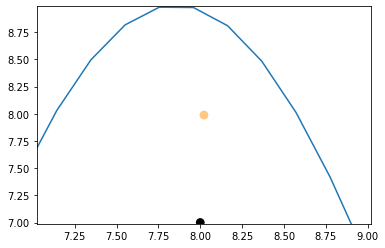

[8.02220098752825, 7.988275506862294]

In [ ]:
X=(8,7)
solveNeuralNet(net,X,labelmaker(f,X),epsilon=1,decision_boundary=True,plot=True)

# Demo 2 | Multi-class Classifier w/ MNIST
---


# Load MNIST

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Scale((8,8))])

mnist_trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

## Visualize Data

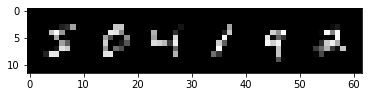

      5       0       4       1       9       2


In [ ]:
import torchvision
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)).squeeze())
  plt.show()

n_img = 6
imgs = [ mnist_trainset[i][0] for i in range(n_img) ]
imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%7s' % mnist_trainset[i][1] for i in range(n_img)))

# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F 

class MNIST_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(8*8,50)
    self.linear2 = nn.Linear(50,30)
    self.linear3 = nn.Linear(30,20)
    self.output = nn.Linear(20,10)

  def forward(self,x):
    x = torch.flatten(x,1)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear3(x))
    return self.output(x)

mnist_net = MNIST_Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_net.parameters(), lr=1e-3, momentum=0.8)

## Train Model

In [ ]:
N_epochs = int(1)
for epoch in range(N_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(mnist_trainset):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels_tensor = torch.LongTensor([labels])
  
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = mnist_net(inputs)
        loss = criterion(input=outputs, target=labels_tensor)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 600 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.304
[1,  4000] loss: 2.294
[1,  6000] loss: 2.261
[1,  8000] loss: 2.110
[1, 10000] loss: 1.794
[1, 12000] loss: 1.425
[1, 14000] loss: 1.229
[1, 16000] loss: 1.061
[1, 18000] loss: 0.971
[1, 20000] loss: 0.816
[1, 22000] loss: 0.742
[1, 24000] loss: 0.700
[1, 26000] loss: 0.659
[1, 28000] loss: 0.662
[1, 30000] loss: 0.616
[1, 32000] loss: 0.666
[1, 34000] loss: 0.559
[1, 36000] loss: 0.530
[1, 38000] loss: 0.524
[1, 40000] loss: 0.518
[1, 42000] loss: 0.484
[1, 44000] loss: 0.500
[1, 46000] loss: 0.497
[1, 48000] loss: 0.461
[1, 50000] loss: 0.450
[1, 52000] loss: 0.443
[1, 54000] loss: 0.443
[1, 56000] loss: 0.384
[1, 58000] loss: 0.388
[1, 60000] loss: 0.264
Finished Training


## Test Model

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in mnist_testset:
        images, labels = data
        labels = torch.LongTensor([labels])
        # calculate outputs by running images through the network
        outputs = mnist_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(mnist_testset)} test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84 %


# Encode as SAT

In [ ]:
X,y = mnist_trainset[0]
X_lst = torch.flatten(X,1).tolist()[0]
X_hat = solveNeuralNet(mnist_net,X_lst,y,epsilon=0.95,input_limit=(0,1))


Given Input: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0066176471300423145, 0.13235294818878174, 0.18602941930294037, 0.638235330581665, 0.0, 0.0, 0.0, 0.7661764621734619, 0.9921569228172302, 0.5936274528503418, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6473039388656616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6308823823928833, 0.3693627715110779, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08602941781282425, 0.8845588564872742, 0.7995098233222961, 0.0, 0.0, 0.0, 0.13995099067687988, 0.9171568751335144, 0.9017156958580017, 0.01985294185578823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Mask Found: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Model Input (Input + Mask): [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

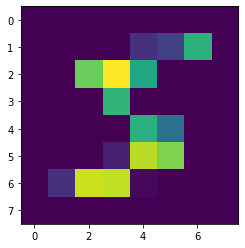

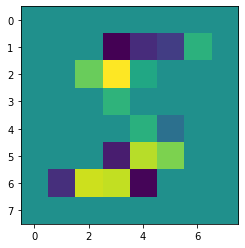

In [ ]:
X_hat = torch.Tensor(np.array(X_hat)).reshape((8,8))
X_hat = torch.unsqueeze(X_hat,0)
imshow(X)
imshow(X_hat)